# Drew Sirenko's sklearn (and Pandas) crash course for NLP
Below you will find a simple template for classification problems, using sklearn's 20 newsgroups text dataset as our example. 

- Make a copy of this by clicking File/Copy Notebook in the toolbar.

- Please RUN the cells in order by clicking the play button on each cell, or clicking Runtime/run_all in the toolbar above. 

- Use the Table of contents button on the left to jump around. 

- Sidenote: Usually Python files have all their imports at the top. I'm going to betray that rule by importing things right before we use them, so you know what's what. 

- Sidenote2: While jupyter notebook's are great for scaffolding code, they don't do the best job of mimicking real Python files. For hw1, you will need to submit a .py file. If you don't want to have to messily convert a notebook into a .py file, I HIGHLY reccomend learning VScode's iPython features to combine the best parts of jupyter notebooks (the running code one cell at a time) while keeping the structure of Python files: https://code.visualstudio.com/docs/python/jupyter-support-py

## Data Prep (Preprocessing and Train/Validation/Test Split)

In this tutorial, we're kind of cheating by just loading the dataset from inside sklearn. In hw1 (and real life), you'll have to create a pipeline to turn some messy json or csv into training/validation/testing data and features. **So think of fetch_20newsgroups as a function you'd have in your features.py**

I've attatched an appendix at the end on my favorite tool to explore data with, Pandas. 



In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

# ALWAYS Shuffle your data!!!
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, 
                                categories= ['alt.atheism', 'talk.religion.misc','comp.graphics', 'sci.space']) 
data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42,
                               categories= ['alt.atheism', 'talk.religion.misc','comp.graphics', 'sci.space'])


# OR when you have one data source and need to manually create train/validation/test splits
"""
data = fetch_20newsgroups(subset='all') 
data_train, data_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.2, random_state=42)
"""

# Don't want to waste so much data just for validation? Do k-fold cross validation 
# with https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
# NOT sklearn's default cross validation functions


"\ndata = fetch_20newsgroups(subset='all') \ndata_train, data_test, y_train, y_test = train_test_split(\n    data.data, data.target, test_size=0.2, random_state=42)\n"

## Feature Generation (And concatenation)
**Think of these functions as what you'd also have in your features.py**

Remember CountVectorizer from hw0? Well sklearn has their own versions (and some are pretty similar to the one you built!)

Vectorizers break up your text_data into ngrams (there's a parameter for it), then count how often they appear!

  - vectorizer.fit learns a vocabulary dictionary of all tokens in the raw documents.
  - vectorizer.transform transforms the text into a SPARSE matrix where: 
    - every column is a separate ngram from the fitted dictionary, 
    - a row for each document in the data, 
    - where each value (i,j) is how many times the jth ngram occured in the ith document
  - vectorizer.fit_transform() applies fit, then transform. Make sure to only fit your vectorizer on the TRAINING data



Sidenote: Features are usually SPARSE matrices, so make sure to use scipy's vstack and hstack to combine features. 
  - More info here: https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

In [5]:
'''These functions would go in features.py'''

'''Create tf-idf vectors for the input'''
from sklearn.feature_extraction.text import CountVectorizer
def get_ngrams(data_train, data_test):
  # Hint! There are a few paramaters for vectorizers in sklearn that might
  # help with this homework! 
  vectorizer = CountVectorizer()


  X_train_ngrams = vectorizer.fit_transform(data_train.data)
  X_test_ngrams = vectorizer.transform(data_test.data)
  return X_train_ngrams, X_test_ngrams


'''Generates noisy features for data'''
import numpy as np
def get_noise(data, cols=5):
  noisy_features = np.random.rand(len(data.data),cols)
  return noisy_features

'''Generates/Concatenates features from data'''
import scipy as sp
from scipy.sparse import coo_matrix, hstack
def get_features(data_train, data_test, model = "Ngrams+noise"):

  # Initialize 'empty' features matrices
  X_train, X_test = np.empty((len(data_train.data), 0)), np.empty((len(data_test.data), 0))
  print(X_train.shape, X_test.shape)

  # Get ngrams features if wanted
  if "ngrams" in model:
    X_train_ngrams, X_test_ngrams = get_ngrams(data_train, data_test)
    # NEED TO hstack with scipy because you're dealing with SPARSE matrices
    print(X_train_ngrams.shape)
    X_train = hstack([X_train, X_train_ngrams])
    X_test = hstack([X_test, X_test_ngrams])

  # Get noisy features if wanted
  if "noise" in model:
    X_train_noise, X_test_noise = get_noise(data_train, cols=2), get_noise(data_test, cols=2)
    X_train = hstack([X_train, X_train_noise])
    X_test = hstack([X_test, X_test_noise])

  return X_train, X_test

def get_labels(data_train, data_test):
  y_train = data_train.target
  y_test = data_test.target
  return y_train, y_test

#---------------------------------------------------------------------------
#---------------------------------------------------------------------------
#---------------------------------------------------------------------------

'''This would go with the rest of your sklearn code'''
model = "ngrams+noise"
X_train, X_test = get_features(data_train, data_test, model=model)
y_train, y_test = get_labels(data_train, data_test)

(2034, 0) (1353, 0)
(2034, 34118)


## Training the model
HEY THERE **Make sure you use a logistic classifier for hw1; check 1.1.11 of the sklearn user guide :)**

Yes it's really that simple, just:
1. Choose one of sklearn's pre-packaged models
2. Play with the parameters (or even better, **grid search** for the best ones)
3. Pass in some SPARSE matrices with your data
4. And call .fit()

- Sidenote: Remember to split your training data again into training and validation sets in order to not overfit your model 
  - (If you're optimizing your paramaters based off of the test set, it won't generalize as well to unseen data) (In hw1 this doesn't matter because we're hiding the real test data)


- Sidenote2: Just going to leave this grid_search tutorial here...
  - https://scikit-learn.org/stable/modules/grid_search.html



In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import MultinomialNB

# Params
n_neighbors = 5
weights = 'uniform'

# clf is short for classifier
# Note that first we instantiate the classifier object with our params
clf = KNeighborsClassifier(n_neighbors, weights=weights)
# THEN we fit it to our data
clf.fit(X_train, y_train)

# And here's a second classifier
clf_MNB = MultinomialNB()
clf_MNB.fit(X_train, y_train)

# Just going to leave this grid_search tutorial here...
# https://scikit-learn.org/stable/modules/grid_search.html

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluate Model on validation/test data

In [ ]:
# All you need is the .predict() function
y_predicted_KNN = clf.predict(X_test)
y_predicted_MNB = clf_MNB.predict(X_test)

## Get some results on how good your models are

NOTE: HW1 has some very specific output instructions that don't include all this stuff, BUT you should still try looking at these metrics to troubleshoot your models. 

KNN Classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.54      0.64      0.58       319
     comp.graphics       0.62      0.78      0.69       389
         sci.space       0.80      0.52      0.63       394
talk.religion.misc       0.47      0.43      0.45       251

          accuracy                           0.61      1353
         macro avg       0.61      0.59      0.59      1353
      weighted avg       0.63      0.61      0.60      1353

Accuracy score:  0.60679970436068
Balanced accuracy score:  0.60679970436068


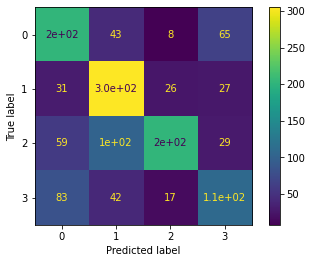

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, plot_confusion_matrix

print('KNN Classification report:')
print(classification_report(y_test, y_predicted_KNN,target_names=data_test.target_names))

print("Accuracy score: ",accuracy_score(y_test, y_predicted_KNN))
print("Balanced accuracy score: ",accuracy_score(y_test, y_predicted_KNN))

plot_confusion_matrix(clf, X_test, y_test)


MNB Classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.80      0.91      0.85       319
     comp.graphics       0.96      0.95      0.95       389
         sci.space       0.94      0.95      0.94       394
talk.religion.misc       0.88      0.73      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.88      0.89      1353
      weighted avg       0.90      0.90      0.90      1353

Accuracy score:  0.8980044345898004
Balanced accuracy score:  0.8980044345898004


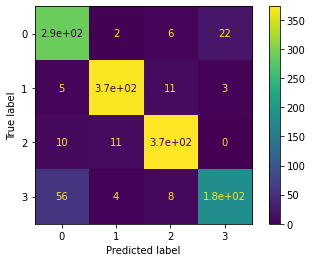

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix

print('MNB Classification report:')
print(classification_report(y_test, y_predicted_MNB,target_names=data_test.target_names))

print("Accuracy score: ",accuracy_score(y_test, y_predicted_MNB))
print("Balanced accuracy score: ",accuracy_score(y_test, y_predicted_MNB))

plot_confusion_matrix(clf_MNB, X_test, y_test)

# Appendix A: Pandas for data exploration and cleaning

In the Sep 24th Tutorial, Drew walked through some exploratory and data-cleaning with Pandas. 

For a more official tutorial, checkout https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html

## Loading data into a dataframe
So let's say you just *happen* to find some data about users who vote on debate forums totally unrelated to HW1. How can you explore it, and pre-process it such that it's ready to train your startup's ML model? 

Well, Pandas let's you read a variety of common filetypes into something called a dataframe (think spreadsheet but cooler & more confusing)

"A dataFrame is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dict of Series objects." 

In [ ]:
import pandas as pd

USER_PATH = "YOUR_HW1_PATH_HERE/Archive/users.json"

# This orient index param is only for users.json
# You might need some other params to read jsonl files...
df_user =pd.read_json(USER_PATH, orient="index") 


## Exploring your data

In [ ]:
# Head function gets you the first n records (rows) in the dataframe
print(df_user.head(5))

# Cleanly returns the columns of your dataframe
print(df_user.columns)

# Get a subset of the columns with the df[[col1, col2]] notation
df_user_subset = df_user[["birthday", "education"]]
print(df_user_subset)

# Any single column of a dataframe is treated as a "Series", kind of like a list
print(df_user_subset["birthday"][0])

# We can filter a dataframe with this notation
df_user_subset_saying = df_user_subset[df_user_subset['education'] != "Not Saying"]
print(df_user_subset_saying)

# We can also count the number of unique values in a column
counts = df_user_subset.nunique()
print(counts)

# And the how often each unique value appears in a column
print(df_user_subset['education'].value_counts())